<a href="https://colab.research.google.com/github/deep-diver/auto-paper-analysis/blob/main/notebooks/analyze_arxiv_pdf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from IPython.display import HTML, display
from IPython.display import Markdown

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [ ]:
!pip install google-generativeai
!pip install pypdf2
!pip install fitz
!pip install pymupdf

In [2]:
GEMINI_API_KEY="..."

In [5]:
import requests

def download_pdf_from_arxiv(arxiv_id):
  url = f'http://export.arxiv.org/pdf/{arxiv_id}'
  response = requests.get(url)
  if response.status_code == 200:
    return response.content
  else:
    raise Exception(f"Failed to download pdf for arXiv id {arxiv_id}")

# Example usage
arxiv_id = "2306.00001"
pdf_content = download_pdf_from_arxiv(arxiv_id)

# Save the pdf content to a file
with open(f"{arxiv_id}.pdf", "wb") as f:
  f.write(pdf_content)


In [6]:
import fitz  # PyMuPDF
import PyPDF2

def extract_text_and_figures(pdf_path):
    """
    Extracts text and figures from a PDF file.

    Args:
        pdf_path (str): The path to the PDF file.

    Returns:
        tuple: A tuple containing two lists:
            * A list of extracted text blocks.
            * A list of extracted figures (as bytes).
    """

    texts = []
    figures = []

    # Open the PDF using PyMuPDF (fitz) for image extraction
    doc = fitz.open(pdf_path)
    for page_num, page in enumerate(doc):
        text = page.get_text("text")  # Extract text as plain text
        texts.append(text)

        # Process images on the page
        image_list = page.get_images()
        for image_index, img in enumerate(image_list):
            xref = img[0]  # Image XREF
            pix = fitz.Pixmap(doc, xref)  # Create Pixmap image

            # Save image in desired format (here, PNG)
            if pix.n < 5:  # Grayscale or RGB
                img_bytes = pix.tobytes("png")
            else:  # CMYK: Convert to RGB first
                pix = fitz.Pixmap(fitz.csRGB, pix)
                img_bytes = pix.tobytes("png")

            figures.append(img_bytes)

    # Extract additional text using PyPDF2 (in case fitz didn't get everything)
    with open(pdf_path, 'rb') as pdf_file:
        pdf_reader = PyPDF2.PdfReader(pdf_file)
        for page_num in range(len(pdf_reader.pages)):
            page = pdf_reader.pages[page_num]
            text = page.extract_text()
            texts.append(text)

    return texts, figures


In [7]:
texts, figures = extract_text_and_figures(f'{arxiv_id}.pdf')

In [8]:
texts[0]

'This paper has been accepted for publication at the\nIEEE Conference on Artiﬁcial Intelligence Circuits and Systems (AICAS), Hangzhou, 2023.\n©2023 IEEE. Personal use of this material is permitted. Permission from IEEE must be obtained for all other uses, in any current or future\nmedia, including reprinting/republishing this material for advertising or promotional purposes, creating new collective works, for resale or\nredistribution to servers or lists, or reuse of any copyrighted component of this work in other works.\nTinyissimoYOLO: A Quantized, Low-Memory\nFootprint, TinyML Object Detection Network for\nLow Power Microcontrollers\nJulian Moosmann, Marco Giordano, Christian Vogt, Michele Magno\nCenter for Project Based Learning - ETH Z¨urich\njulian.moosmann, marco.giordano, christian.vogt, michele.magno@pbl.ee.ethz.ch\nAbstract—This paper introduces a highly ﬂexible, quantized,\nmemory-efﬁcient, and ultra-lightweight object detection network,\ncalled TinyissimoYOLO. It aims to e

In [9]:
print(len(figures))
print(type(figures[0]))

1
<class 'bytes'>


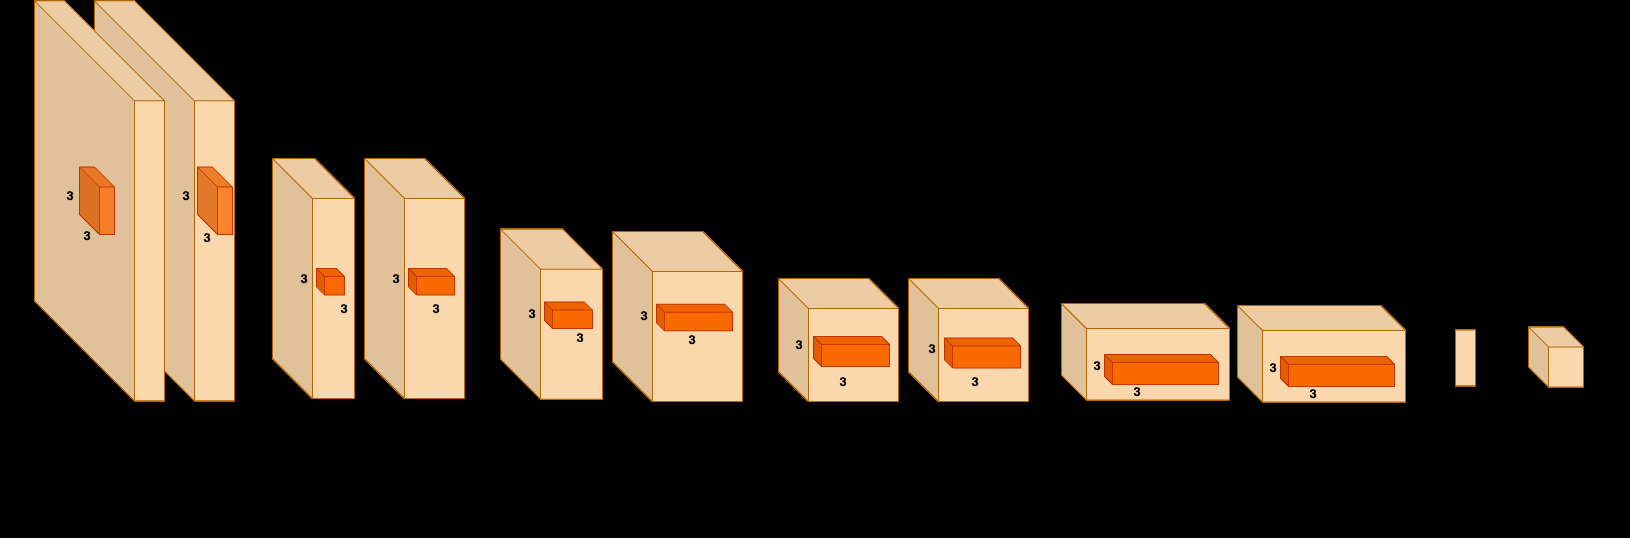

In [10]:
import io
from PIL import Image

img = Image.open(io.BytesIO(figures[0]))
display(img)

In [49]:
def determine_model_name(given_image=None):
  if given_image is None:
    return "gemini-pro"
  else:
    return "gemini-pro-vision"

def construct_image_part(given_image):
  return {
    "mime_type": "image/jpeg",
    "data": given_image
  }

def construct_blog_part(given_blob, mime_type="pdf/application"):
  return {
      "mime_type": mime_type,
      "data": given_blob
  }

def call_gemini(prompt="", API_KEY=None, given_text=None, given_image=None, given_blob=None, generation_config=None, safety_settings=None):
  import google.generativeai as genai
  genai.configure(api_key=API_KEY)

  if generation_config is None:
    generation_config = {
      "temperature": 0.4,
      "top_p": 1,
      "top_k": 32,
      "max_output_tokens": 8192,
    }

  if safety_settings is None:
    safety_settings = [
      {
        "category": "HARM_CATEGORY_HARASSMENT",
        "threshold": "BLOCK_ONLY_HIGH"
      },
      {
        "category": "HARM_CATEGORY_HATE_SPEECH",
        "threshold": "BLOCK_ONLY_HIGH"
      },
      {
        "category": "HARM_CATEGORY_SEXUALLY_EXPLICIT",
        "threshold": "BLOCK_ONLY_HIGH"
      },
      {
        "category": "HARM_CATEGORY_DANGEROUS_CONTENT",
        "threshold": "BLOCK_ONLY_HIGH"
      },
    ]

  model_name = determine_model_name(given_image)
  model = genai.GenerativeModel(model_name=model_name,
                                generation_config=generation_config,
                                safety_settings=safety_settings)

  USER_PROMPT = prompt
  if given_text is not None:
    USER_PROMPT += f"""{prompt}
  ------------------------------------------------
  {given_text}
  """
  prompt_parts = [USER_PROMPT]
  if given_image is not None:
    prompt_parts.append(construct_image_part(given_image))
  if given_blob is not None:
    prompt_parts.append(construct_blog_part(given_blob))

  response = model.generate_content(prompt_parts)
  return response.text

In [22]:
import json

def find_json_snippet(raw_snippet):
	json_parsed_string = None

	json_start_index = raw_snippet.find('{')
	json_end_index = raw_snippet.rfind('}')

	if json_start_index >= 0 and json_end_index >= 0:
		json_snippet = raw_snippet[json_start_index:json_end_index+1]
		try:
			json_parsed_string = json.loads(json_snippet, strict=False)
		except:
			raise ValueError('failed to parse string into JSON format')
	else:
		raise ValueError('No JSON code snippet found in string.')

	return json_parsed_string

def parse_first_json_snippet(snippet):
	json_parsed_string = None

	if isinstance(snippet, list):
		for snippet_piece in snippet:
			try:
				json_parsed_string = find_json_snippet(snippet_piece)
				return json_parsed_string
			except:
				pass
	else:
		try:
			json_parsed_string = find_json_snippet(snippet)
		except Exception as e:
			print(e)
			raise ValueError()

	return json_parsed_string

In [23]:
text =' '.join(texts)

In [64]:
prompt = """
come up with the 10 questions and answers that could be commonly asked by people about the following paper.
There should be two types of answers included, one for expert and the other for ELI5.
Your response should be recorded in a JSON format as ```json{"title": text, "summary": text, "qna": [{"question": "answers": {"eli5": text, "expert": text}}, ...]}```
"""

In [65]:
qna_json = None
cur_retry = 0
retry_num = 5

while qna_json is None and cur_retry < retry_num:
  try:
    qna = call_gemini(
        prompt=prompt,
        given_text=text,
        API_KEY=GEMINI_API_KEY
    )

    qna_json = parse_first_json_snippet(qna)
  except:
    cur_retry = cur_retry + 1
    print("retry")

In [66]:
qna_json

{'title': 'TinyissimoYOLO: A Quantized, Low-Memory Footprint, TinyML Object Detection Network for Low Power Microcontrollers',
 'summary': 'This paper proposes a quantized and highly accurate object detection convolutional neural network (CNN) based on the architecture of YOLO [4] suitable for edge processors with limited memory and computational resources. The proposed network is composed of quantized convolutional layers with 3x3 kernels and a fully connected layer at the output. It is designed for having a low memory footprint of less than 0.5MB. The proposed network is trained and evaluated on the WiderFace dataset [18]. Furthermore, to showcase multi-object detection capability, while keeping the network small, it has been trained and evaluated on a sub-set of the PascalVOC [19] dataset (3 out of the 20 classes, namely: person, chair and car). Finally, the network is deployed quantized and memory-efficient on different microcontrollers, such as the STM32H7A3 and STM32L4R9 from STM

In [67]:
qna_json['summary']

'This paper proposes a quantized and highly accurate object detection convolutional neural network (CNN) based on the architecture of YOLO [4] suitable for edge processors with limited memory and computational resources. The proposed network is composed of quantized convolutional layers with 3x3 kernels and a fully connected layer at the output. It is designed for having a low memory footprint of less than 0.5MB. The proposed network is trained and evaluated on the WiderFace dataset [18]. Furthermore, to showcase multi-object detection capability, while keeping the network small, it has been trained and evaluated on a sub-set of the PascalVOC [19] dataset (3 out of the 20 classes, namely: person, chair and car). Finally, the network is deployed quantized and memory-efficient on different microcontrollers, such as the STM32H7A3 and STM32L4R9 from STMicroelectronics, Ambiq’s Apollo4b and on a novel microcontroller, MAX78000 from Analog Devices, which has a built-in CNN accelerator. The p

In [68]:
qna_json['qna']

[{'question': 'What is the main contribution of this paper?',
  'answers': {'eli5': 'The paper presents a new object detection network called TinyissimoYOLO, which is designed to be small and efficient enough to run on low-power microcontrollers. This network can be used to detect objects in real-time on devices like smartphones and embedded systems.',
   'expert': 'The main contribution of this paper is the proposal of a quantized and highly accurate object detection convolutional neural network (CNN) based on the architecture of YOLO [4] suitable for edge processors with limited memory and computational resources.'}},
 {'question': 'What are the key features of TinyissimoYOLO?',
  'answers': {'eli5': 'TinyissimoYOLO is a small and efficient object detection network that can run on low-power microcontrollers. It is designed to have a low memory footprint of less than 0.5MB and can be deployed on a variety of different microcontrollers.',
   'expert': 'The key features of TinyissimoYOL

In [ ]:
fig0_desc = call_gemini(
    prompt=f'Below is the summary of the academic paper, {qna_json["title"]}. '
           'Based on the summary, give me the description of the given figure. '
           'Give me your response by filling in the following JSON. '
           '{"description": text}',
    given_text=qna_json['summary'],
    given_image=figures[0],
    API_KEY=GEMINI_API_KEY
)

In [30]:
fig0_desc

' {"description": "The figure shows the architecture of the proposed TinyissimoYOLO network. It consists of a series of convolutional layers, each followed by a batch normalization layer and a ReLU activation function. The first convolutional layer has a kernel size of 3x3 and a stride of 2, and the remaining convolutional layers have a kernel size of 3x3 and a stride of 1. The network also includes two max pooling layers, each with a kernel size of 2x2 and a stride of 2. The final layer is a fully connected layer that outputs the class probabilities and bounding boxes for the detected objects."}'

## Analyze deeper

### Title

In [69]:
Markdown(f"# {qna_json['title']}")

# TinyissimoYOLO: A Quantized, Low-Memory Footprint, TinyML Object Detection Network for Low Power Microcontrollers

### Summary

In [70]:
Markdown(f"### {qna_json['summary']}")

### This paper proposes a quantized and highly accurate object detection convolutional neural network (CNN) based on the architecture of YOLO [4] suitable for edge processors with limited memory and computational resources. The proposed network is composed of quantized convolutional layers with 3x3 kernels and a fully connected layer at the output. It is designed for having a low memory footprint of less than 0.5MB. The proposed network is trained and evaluated on the WiderFace dataset [18]. Furthermore, to showcase multi-object detection capability, while keeping the network small, it has been trained and evaluated on a sub-set of the PascalVOC [19] dataset (3 out of the 20 classes, namely: person, chair and car). Finally, the network is deployed quantized and memory-efficient on different microcontrollers, such as the STM32H7A3 and STM32L4R9 from STMicroelectronics, Ambiq’s Apollo4b and on a novel microcontroller, MAX78000 from Analog Devices, which has a built-in CNN accelerator. The performance of the different architectures is compared and it will be shown, how the MAX78000 outperforms the other microcontrollers. Furthermore, this paper investigates the effect of mAP against relative object size dimensions within images. This evaluation helps to understand which object size should be chosen when training the generalized object detection network.

### QnAs

In [71]:
for qna in qna_json['qna']:
  q = qna['question']
  a_eli5 = qna['answers']['eli5']
  a_expert = qna['answers']['expert']

  print(f"⦿ {q}")
  print(f"-- ELI5: {a_eli5}")
  print(f"-- Expert: {a_expert}\n")

⦿ What is the main contribution of this paper?
-- ELI5: The paper presents a new object detection network called TinyissimoYOLO, which is designed to be small and efficient enough to run on low-power microcontrollers. This network can be used to detect objects in real-time on devices like smartphones and embedded systems.
-- Expert: The main contribution of this paper is the proposal of a quantized and highly accurate object detection convolutional neural network (CNN) based on the architecture of YOLO [4] suitable for edge processors with limited memory and computational resources.

⦿ What are the key features of TinyissimoYOLO?
-- ELI5: TinyissimoYOLO is a small and efficient object detection network that can run on low-power microcontrollers. It is designed to have a low memory footprint of less than 0.5MB and can be deployed on a variety of different microcontrollers.
-- Expert: The key features of TinyissimoYOLO are: 
- It is a quantized network, which means that the weights of th

### More QnAs

In [72]:
deep_prompt = """
Paper title: %s
Previous question: %s
The answer on the previous question: %s

Based on the previous question and answer above, and based on the paper content below,
Then, suggest follow-up question and answers in %s manner.

There should be two types of answers included, one for expert and the other for ELI5.
Your response should be recorded in a JSON format as ```json{"follow up question": text, "answer": {"eli5": text, "expert": text}}```"""

In [73]:
title = qna_json['title']

In [74]:
def try_out(prompt, given_text, given_image=None, gemini_api_key=GEMINI_API_KEY, retry_num=3):
  qna_json = None
  cur_retry = 0

  while qna_json is None and cur_retry < retry_num:
    try:
      qna = call_gemini(
          prompt=prompt,
          given_text=given_text,
          given_image=given_image,
          API_KEY=gemini_api_key
      )

      qna_json = parse_first_json_snippet(qna)
    except:
      cur_retry = cur_retry + 1
      print("retry")

  return qna_json

In [111]:
import copy

qnas = copy.deepcopy(qna_json['qna'])

for qna in qnas:
  q = qna['question']
  a_expert = qna['answers']['expert']

  depth_search_prompt = deep_prompt % (title, q, a_expert, "in-depth")
  breath_search_prompt = deep_prompt % (title, q, a_expert, "broad")

  depth_search_response = try_out(depth_search_prompt, text, gemini_api_key=GEMINI_API_KEY)
  breath_search_response = try_out(breath_search_prompt, text, gemini_api_key=GEMINI_API_KEY)

  if depth_search_response is not None:
    qna['additional_depth_q'] = depth_search_response
  if breath_search_response is not None:
    qna['additional_breath_q'] = breath_search_response

No JSON code snippet found in string.
retry


In [112]:
qnas[0]

{'question': 'What is the main contribution of this paper?',
 'answers': {'eli5': 'The paper presents a new object detection network called TinyissimoYOLO, which is designed to be small and efficient enough to run on low-power microcontrollers. This network can be used to detect objects in real-time on devices like smartphones and embedded systems.',
  'expert': 'The main contribution of this paper is the proposal of a quantized and highly accurate object detection convolutional neural network (CNN) based on the architecture of YOLO [4] suitable for edge processors with limited memory and computational resources.'},
 'additional_depth_q': {'follow up question': 'What is the main contribution of this paper?',
  'answer': {'eli5': 'This paper introduces a new object detection network called TinyissimoYOLO. This network is designed to run on tiny microcontrollers with less than 0.5 MB of memory. TinyissimoYOLO is able to detect multiple objects in real-time on embedded microcontrollers, a

In [113]:
qnas

[{'question': 'What is the main contribution of this paper?',
  'answers': {'eli5': 'The paper presents a new object detection network called TinyissimoYOLO, which is designed to be small and efficient enough to run on low-power microcontrollers. This network can be used to detect objects in real-time on devices like smartphones and embedded systems.',
   'expert': 'The main contribution of this paper is the proposal of a quantized and highly accurate object detection convolutional neural network (CNN) based on the architecture of YOLO [4] suitable for edge processors with limited memory and computational resources.'},
  'additional_depth_q': {'follow up question': 'What is the main contribution of this paper?',
   'answer': {'eli5': 'This paper introduces a new object detection network called TinyissimoYOLO. This network is designed to run on tiny microcontrollers with less than 0.5 MB of memory. TinyissimoYOLO is able to detect multiple objects in real-time on embedded microcontrolle

## Gradio UI

In [ ]:
!pip install gradio

In [114]:
import gradio as gr

STYLE = """
.small-font{
  font-size: 12pt;
}

.group {
  padding-left: 10px;
  padding-right: 10px;
  padding-bottom: 10px;
  border: 1px dashed black;
  border-radius: 20px;
}
"""

with gr.Blocks(css=STYLE) as demo:
  gr.Markdown(f"# {qna_json['title']}")
  gr.Markdown(f"{qna_json['summary']}")

  gr.Markdown("# Auto generated Questions & Answers")

  for qna in qnas:
    with gr.Column(elem_classes=["group"]):
      gr.Markdown(f"## {qna['question']}")
      gr.Markdown(qna['answers']['eli5'], elem_classes=["small-font"])

      with gr.Accordion("More technical answer", open=False):
        gr.Markdown(qna['answers']['expert'], elem_classes=["small-font"])

      with gr.Accordion("Additional question (depth)", open=False):
        gr.Markdown(f"## {qna['additional_depth_q']['follow up question']}")
        gr.Markdown(qna['additional_depth_q']['answer']['eli5'], elem_classes=["small-font"])

        with gr.Accordion("More technical answer", open=False):
          gr.Markdown(qna['additional_depth_q']['answer']['expert'], elem_classes=["small-font"])

      with gr.Accordion("Additional question (breath)", open=False):
        gr.Markdown(f"## {qna['additional_breath_q']['follow up question']}")
        gr.Markdown(qna['additional_breath_q']['answer']['eli5'], elem_classes=["small-font"])

        with gr.Accordion("More technical answer", open=False):
          gr.Markdown(qna['additional_breath_q']['answer']['expert'], elem_classes=["small-font"])

demo.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://4a527151a0527e7553.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
